Team Name: Pathfinder \
Team Member: Vignesh S S\
Problem Statememnt: AI-Based Computer Vision for Healthcare Hackathon\
Dataset Link: https://drive.google.com/drive/u/1/folders/1UVvAea975DxWIYFSULqmqVMKLquBOs1Y \

**Image quality analyser based on outputs of Segmentation and Landmark prediction made**
Hypothesis - 2 with Attention Unet




In [ ]:
# Cell 1: Install all required libraries
!pip install -U torchmetrics albumentations segmentation-models-pytorch

In [17]:
from google.colab import drive
import os

# Mount your Google Drive at /content/drive
drive.mount('/content/drive', force_remount=True)

# --- Configuration ---
# IMPORTANT: Make sure this is the exact name of your zip file
# (I removed the starting '/' which is safer)
ZIP_FILE_NAME = "Hackathon_Dataset_20251025T071740Z.zip"

# --- 1. FIXED PATH ---
# The path *must* start with /content/drive/My Drive/
ZIP_PATH_ON_DRIVE = f"/content/{ZIP_FILE_NAME}"
UNZIP_DESTINATION = "/content/"  # Unzips to the fast local /content/ disk

# --- Unzip Logic ---
if os.path.exists(ZIP_PATH_ON_DRIVE):
    print(f"Found zip file at: {ZIP_PATH_ON_DRIVE}")
    print("Unzipping to local disk... This may take a minute.")

    # --- 2. FIXED COMMAND ---
    # -q = quiet (no file list)
    # -o = overwrite (no prompts)
    !unzip -q -o "{ZIP_PATH_ON_DRIVE}" -d "{UNZIP_DESTINATION}"

    print("Unzipping complete!")

    # Verify the expected folder is now present
    print("Contents of /content/ (your unzipped data):")
    !ls "/content/"
else:
    print(f"ERROR: Zip file not found at: {ZIP_PATH_ON_DRIVE}")
    print("Please check the file name and its location in your Google Drive.")

Mounted at /content/drive
Found zip file at: /content/Hackathon_Dataset_20251025T071740Z.zip
Unzipping to local disk... This may take a minute.
Unzipping complete!
Contents of /content/ (your unzipped data):
 drive					  new_img     new_img_5   sample_data
'Hackathon Dataset'			  new_img_2   new_img6
 Hackathon_Dataset_20251025T071740Z.zip   new_img_4   New_video


In [18]:
#The Complete IQA + AI Pipeline

# --- 1. Imports ---
import torch
import torch.nn as nn
import cv2  # OpenCV
import numpy as np
import os
from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp
from google.colab import drive
import base64
import warnings

In [19]:
from google.colab.patches import cv2_imshow # To display images in Colab
from IPython.display import HTML # To embed videos in Colab

In [21]:
# Suppress all warnings for a clean final output
warnings.filterwarnings("ignore")

# --- 2. Mount Drive & Define Paths ---
print("Mounting Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"Drive mount failed: {e}")

# --- Path Configuration ---
DRIVE_PATH = "/content/drive/My Drive/"
LOCAL_DATA_PATH = "/content/Hackathon Dataset/"
TARGET_IMG_SIZE = (384, 384)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model Paths (on Google Drive)
SEG_MODEL_PATH = os.path.join(
    DRIVE_PATH,
    "hackathon_submission/task_1_segmentation/Model Weights/best_model_hypothesis_2.pth"
)
LAND_MODEL_PATH = os.path.join(
    DRIVE_PATH,
    "hackathon_submission/task_1_landmark/Model Weights/best_model_hypothesis_1.pth"
)

# Output Video Paths
SAVE_VIDEO_PATH = os.path.join(
    DRIVE_PATH, "hackathon_submission/Results/Video1_output_final.mp4"
)
LOCAL_VIDEO_PATH = "/content/Video1_output_final.mp4"  # For faster writing & embedding
os.makedirs(os.path.dirname(SAVE_VIDEO_PATH), exist_ok=True)


# --- 3. Re-define Model Architectures (to load weights) ---

print("Defining model architectures...")
# Model 1: Segmentation (The Attention U-Net you trained)
seg_model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights=None,
    in_channels=1,
    classes=3,
    decoder_attention_type='scse'  # This makes it an Attention U-Net
).to(DEVICE)

# Model 2: Landmark (The ResNet-34 based model you trained)
class LandmarkUNet(nn.Module):
    """
    Defines the landmark model architecture (ResNet-34 Encoder + Regression Head)
    so we can load our saved weights.
    """
    def __init__(self, n_outputs=4):
        super().__init__()
        self.base_model = smp.Unet(
            encoder_name="resnet34",  # This must match your landmark training
            encoder_weights=None,
            in_channels=1,
            classes=3
        )
        self.encoder = self.base_model.encoder
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        features = self.encoder(x)
        x = features[-1]  # Get the deepest feature map
        x = self.pooling(x)
        x = self.flatten(x)
        x = self.head(x)
        return x

land_model = LandmarkUNet(n_outputs=4).to(DEVICE)

Mounting Google Drive...
Mounted at /content/drive
Defining model architectures...


In [22]:
#--- 4. Load Saved Model Weights ---
print(f"Loading models from {DRIVE_PATH}...")
try:
    # Load the "state dictionary" (the trained weights)
    seg_model.load_state_dict(torch.load(SEG_MODEL_PATH, map_location=DEVICE))
    land_model.load_state_dict(torch.load(LAND_MODEL_PATH, map_location=DEVICE))

    # Set models to evaluation mode (disables dropout, etc.)
    seg_model.eval()
    land_model.eval()
    print("Models loaded successfully.")
except Exception as e:
    print(f"--- FATAL ERROR: Could not load models. Check paths. {e} ---")
    raise e

Loading models from /content/drive/My Drive/...
Models loaded successfully.


In [23]:
# --- 5. Helper Functions ---

def letterbox_frame(image_gray, target_size=(384, 384)):
    """
    Pads a grayscale image to a target square size, maintaining aspect ratio.

    Args:
        image_gray (np.array): The input grayscale frame.
        target_size (tuple): The (height, width) of the output.

    Returns:
        tuple: (tensor_image, padded_image_gray, scale_info)
    """
    h, w = image_gray.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)

    resized_image = cv2.resize(
        image_gray, (new_w, new_h), interpolation=cv2.INTER_LINEAR
    )

    # Calculate padding
    top = (target_size[0] - new_h) // 2
    left = (target_size[1] - new_w) // 2
    bottom = target_size[0] - new_h - top
    right = target_size[1] - new_w - left

    padded_image_gray = cv2.copyMakeBorder(
        resized_image, top, bottom, left, right,
        borderType=cv2.BORDER_CONSTANT, value=0
    )

    # Store scale and padding info to un-scale landmarks later
    scale_info = (scale, left, top)

    # Convert to PyTorch tensor for the model
    tensor_image = torch.from_numpy(padded_image_gray).float().unsqueeze(0).unsqueeze(0)
    tensor_image = (tensor_image / 255.0).to(DEVICE)

    return tensor_image, padded_image_gray, scale_info


def get_circularity(mask):
    """Calculates the circularity of a binary mask."""
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    if not contours:
        return 0.0

    # Assume the largest contour is the one we want
    contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0:
        return 0.0

    # Circularity formula: 1.0 = perfect circle
    return (4 * np.pi * area) / (perimeter**2)

In [36]:
# --- 6. The Final IQA Function ---

# --- THRESHOLDS (Based on our debugging) ---
MIN_THORAX_AREA = 2500      # High-confidence check for Thorax
MIN_THORAX_CIRCULARITY = 0.7   # High-confidence check for Thorax
MIN_CARDIAC_AREA = 0      # *** LOW-confidence check for Heart ***

def run_iqa(frame_tensor, seg_model, frame_num):
    """
    Runs a hierarchical IQA check.
    Fails if Thorax is bad, OR if Heart is *completely* missing.
    Returns the status and the full prediction mask.
    """
    with torch.no_grad():
        mask_logits = seg_model(frame_tensor)
        mask_pred = torch.argmax(mask_logits, dim=1).squeeze().cpu().numpy().astype(np.uint8)

    # --- 1. Strong check on Thorax ---
    thorax_area = np.sum(mask_pred == 2)
    thorax_mask = np.where(mask_pred == 2, 255, 0).astype(np.uint8)
    circularity = get_circularity(thorax_mask)

    # --- 2. Weak check on Heart ---
    cardiac_area = np.sum(mask_pred == 1)

    # --- Debug Print (every not 10 let's do every frames) ---
    if frame_num % 1 == 0:
        print(f"  [Frame {frame_num} IQA: "
              f"T.Area={thorax_area} (Min={MIN_THORAX_AREA}), "
              f"Circ={circularity:.2f} (Min={MIN_THORAX_CIRCULARITY}), "
              f"C.Area={cardiac_area} (Min={MIN_CARDIAC_AREA})]")

    # --- Check Rules ---
    if thorax_area < MIN_THORAX_AREA:
        return "FAIL: Thorax Area", None
    if circularity < MIN_THORAX_CIRCULARITY:
        return "FAIL: Thorax Shape", None
    if cardiac_area < MIN_CARDIAC_AREA:
        return "FAIL: Heart Area", None

    # If all pass, return the mask for drawing
    return "PASS", mask_pred


--- Starting AI Pipeline for /content/Hackathon Dataset/Videos/Video1.mp4 ---
  [Frame 0 IQA: T.Area=3582 (Min=2500), Circ=0.87 (Min=0.7), C.Area=0 (Min=0)]

--- FIRST FRAME THAT PASSED IQA ---


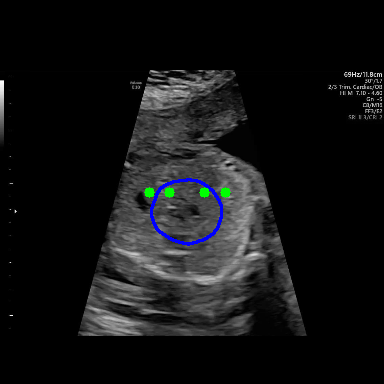

-----------------------------------
  [Frame 1 IQA: T.Area=3772 (Min=2500), Circ=0.85 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 2 IQA: T.Area=4023 (Min=2500), Circ=0.87 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 3 IQA: T.Area=4232 (Min=2500), Circ=0.89 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 4 IQA: T.Area=4513 (Min=2500), Circ=0.88 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 5 IQA: T.Area=4403 (Min=2500), Circ=0.88 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 6 IQA: T.Area=4255 (Min=2500), Circ=0.88 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 7 IQA: T.Area=4368 (Min=2500), Circ=0.88 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 8 IQA: T.Area=4438 (Min=2500), Circ=0.88 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 9 IQA: T.Area=4422 (Min=2500), Circ=0.88 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 10 IQA: T.Area=4339 (Min=2500), Circ=0.86 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 11 IQA: T.Area=4328 (Min=2500), Circ=0.87 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 12 IQA: T.Area=4262 (Min=2500), Circ=0.88 (Min=0.7), C.Area=0 (Min=0)]
  [Frame 13 I

In [37]:
# --- 7. The Main AI Pipeline ---

VIDEO_PATH = os.path.join(LOCAL_DATA_PATH, "Videos/Video1.mp4")
print(f"\n--- Starting AI Pipeline for {VIDEO_PATH} ---")

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print(f"ERROR: Could not open video file: {VIDEO_PATH}")
else:
    # Get video properties to create the output video
    frame_width = int(TARGET_IMG_SIZE[1])
    frame_height = int(TARGET_IMG_SIZE[0])
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4

    # Create the VideoWriter object to save the video
    out_video = cv2.VideoWriter(
        LOCAL_VIDEO_PATH, fourcc, fps, (frame_width, frame_height)
    )

    frame_count = 0
    saved_frame_count = 0
    first_pass_shown = False

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # 1. Preprocess: Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 2. Preprocess: Letterbox and convert to tensor
        frame_tensor, frame_padded_gray, scale_info = letterbox_frame(frame_gray)

        # 3. Create the output frame (color)
        frame_to_draw = cv2.cvtColor(frame_padded_gray, cv2.COLOR_GRAY2BGR)

        # 4. Run IQA (Task 3)
        quality_status, mask_pred = run_iqa(frame_tensor, seg_model, frame_count)

        # 5. Run Main Logic if IQA Passed
        if quality_status == "PASS":

            # --- 5a. Draw Segmentation Contours ---
            # Create binary masks for contours
            cardiac_mask = np.where(mask_pred == 1, 255, 0).astype(np.uint8)
            thorax_mask = np.where(mask_pred == 2, 255, 0).astype(np.uint8)

            # Find and draw cardiac contours (Red, thickness 2)
            contours_cardiac, _ = cv2.findContours(
                cardiac_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )
            cv2.drawContours(frame_to_draw, contours_cardiac, -1, (0, 0, 255), 2)

            # Find and draw thorax contours (Blue, thickness 2)
            contours_thorax, _ = cv2.findContours(
                thorax_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )
            cv2.drawContours(frame_to_draw, contours_thorax, -1, (255, 0, 0), 2)

            # --- 5b. Run Landmark Model (Task 2) ---
            with torch.no_grad():
                norm_landmarks = land_model(frame_tensor)

            # Convert normalized [0,1] coordinates back to [0, 384]
            scale, pad_left, pad_top = scale_info
            landmarks = norm_landmarks.cpu().numpy().squeeze()
            landmarks = (landmarks * TARGET_IMG_SIZE[1])  # Un-normalize

            # Draw CTR points (Green filled circles)
            center_y = TARGET_IMG_SIZE[0] // 2
            for x_coord in landmarks:
                cv2.circle(
                    img=frame_to_draw, center=(int(x_coord), center_y),
                    radius=5, color=(0, 255, 0), thickness=-1
                )

            saved_frame_count += 1

            # --- Show first good frame in Colab ---
            if not first_pass_shown:
                print("\n--- FIRST FRAME THAT PASSED IQA ---")
                cv2_imshow(frame_to_draw)
                print("-----------------------------------")
                first_pass_shown = True

        # Add a text overlay showing IQA status (PASS or FAIL)
        text_color = (0, 255, 0) if quality_status == "PASS" else (0, 0, 255)
        cv2.putText(frame_to_draw, f"IQA: {quality_status}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, text_color, 2)

        # 6. Write the frame to the output video
        out_video.write(frame_to_draw)
        frame_count += 1

In [38]:
# --- 8. Cleanup and Finalize ---
cap.release()
out_video.release()
print("--- Pipeline Finished ---")
print(f"Processed {frame_count} total frames.")
print(f"Saved {saved_frame_count} frames with landmarks and contours.")

# 9. Copy final video to Google Drive for submission
print("Copying video to Google Drive...")
!cp "{LOCAL_VIDEO_PATH}" "{SAVE_VIDEO_PATH}"
print(f"Final video saved to: {SAVE_VIDEO_PATH}")

# --- 10. Embed Final Video in Colab for Review ---
print("\n--- Embedding Final Video for Review ---")
try:
    video_file = open(LOCAL_VIDEO_PATH, "rb").read()
    video_url = f"data:video/mp4;base64,{base64.b64encode(video_file).decode()}"
    display(HTML(f"""
    <video width="640" height="480" controls>
      <source src="{video_url}" type="video/mp4">
    </video>"""))
except FileNotFoundError:
    print(f"Error: Could not find local video file at {LOCAL_VIDEO_PATH} to display.")

--- Pipeline Finished ---
Processed 107 total frames.
Saved 91 frames with landmarks and contours.
Copying video to Google Drive...
Final video saved to: /content/drive/My Drive/hackathon_submission/Results/Video1_output_final.mp4

--- Embedding Final Video for Review ---
